In [1]:
from zoish.feature_selectors.randomshap import RandomizedSearchCVShapFeatureSelector
import logging
import numpy as np
import pandas as pd
import xgboost
import xgbse
from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index, approx_brier_score,dist_calibration_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 432x288 with 0 Axes>

# Install pytorch, pycox needs it

In [2]:
!pip3 install torch torchvision torchaudio



[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


# Example : XGBoost Survival Embeddings (XGBSEKaplanNeighbors)
For more information refer to this link :
https://loft-br.github.io/xgboost-survival-embeddings/examples/confidence_interval.html

# Data

In [3]:
from pycox.datasets import metabric
# read data metabric
data = metabric.read_df()
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


# Define labels in this example: 

y for feature selection (if you want to feature selection based on event)
y_fs = data['event']

Also in grid_xgbse bellow,  xgbse_focus should be set = "event",


y for feature selection (if you want to perform feature selection based on duration)
y_fs = data['duration']

Also in grid_xgbse bellow,  xgbse_focus should be set = "duration",



In [4]:

# splitting to X, T, E format
X = data.drop(['duration', 'event'], axis=1)
T = data['duration']
E = data['event']
y = convert_to_structured(T, E)
# y for for feature selection (if you want do feature selection based on event)
# y_fs = data[['event']]
# also in grid_xgbse should set xgbse_model_needed = "classification",


# y for for feature selection (if you want do feature selection based on duration)
# y_fs = data[['duration']]
# also in grid_xgbse should set xgbse_model_needed = "regression",

y_fs = data[['event']]
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS



array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

In [5]:
y_fs.head()

,event
0,0
1,1
2,0
3,0
4,1


# Train test split for feature selection and for the model itself

splitting between train and validation (the following uses for the feature selection step - random_state should be the same in both)
 - X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)

splitting between train and validation (the following uses for the main model - random_state should be the same in both)
- _ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)


In [6]:
# splitting between train, and validation (the following is for feature selection step - random_state should be same in both)
X_train, X_test, y_train_fs, y_test_fs = train_test_split(X, y_fs, test_size=1/3, random_state = 0)
# splitting between train, and validation (the following is for fit main model - random_state should be same in both)
_ , _ , y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)


# Define Feature selector and set its arguments  

The feature selector in this example (or when the focus is on "duration") will use XGBRegressor.

So estimator_params should be matched with XGBRegressor.

In [7]:
random_xgbse = RandomizedSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=3,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator_params={
        "max_depth": [4, 30],
        "min_child_weight": [0.1, 0.9],
        "n_estimators" :[100,1000],
        "gamma": [1, 9],
        },
        estimator=xgbse.XGBSEDebiasedBCE(lr_params=None, n_jobs=-1,xgb_params=None ),
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## grid search params
        performance_metric = 'cind',
        cv = KFold(n_splits=3, shuffle=True),
        n_iter=4,
        # this argument is necessary and only 
        # meaningful for Survival Embedding
        xgbse_focus = "event",

)


root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for xgbse_focus
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
                 xgb_params={'aft_loss_distribution': 'normal',
                             'aft_loss_distribution_scale': 1,
                             'booster': 'dart', 'colsample_bynode': 0.5,
                             'eval_metric': 'aft-nloglik',
                             'learning_rate': 0.05, 'max_depth': 8,
                             'min_child_weight': 50,
                             'objective': 'survival:aft', 'subsample': 0.5,
    

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline 

(in this example only feature selector, because features already in
form of numbers)

root - INFO - Getting value for estimator
root - INFO - Getting value for estimator_params
root - INFO - Getting value for performance metric
root - INFO - Getting value for verbose
root - INFO - Getting value for random_search_n_jobs
root - INFO - Getting value for n_iter
root - INFO - Getting value for cv
root - INFO - Getting value for xgbse_focus


Fitting 3 folds for each of 4 candidates, totalling 12 fits


Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/xgbse/metrics.py", line 52, in concordance_index
    risks = 1 - survival.mean(axis=1)
  File "/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/numpy/core/_methods.py", line 167, in _mean
    rcount = _count_reduce_items(arr, axis,

[CV 1/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=100;, score=nan total time=   0.3s
[CV 2/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=100;, score=nan total time=   0.2s
[CV 3/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=100;, score=nan total time=   0.2s
[CV 1/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=1000;, score=nan total time=   2.1s
[CV 2/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=1000;, score=nan total time=   2.0s
[CV 3/3] END gamma=9, max_depth=30, min_child_weight=0.9, n_estimators=1000;, score=nan total time=   2.0s
[CV 1/3] END gamma=9, max_depth=4, min_child_weight=0.1, n_estimators=1000;, score=nan total time=   0.6s
[CV 2/3] END gamma=9, max_depth=4, min_child_weight=0.1, n_estimators=1000;, score=nan total time=   0.6s
[CV 3/3] END gamma=9, max_depth=4, min_child_weight=0.1, n_estimators=1000;, score=nan total time=   0.6s
[CV 1/3] END gamma=1, max_depth=4, min_chil

One or more of the test scores are non-finite: [nan nan nan nan]
root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


XGBRegressor


root - INFO - Getting value for plot shap summary
root - INFO - Getting value for n_features


.values =
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08747166],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.13268902],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08747166],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08747166],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08747166],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08747166]])

.base_values =
array([[0.57683277],
       [0.57683277],
       [0.57683277],
       ...,
       [0.57683277],
       [0.57683277],
       [0.57683277]])

.data =
array([[ 5.259714 ,  7.07262  , 11.602811 , ...,  0.       ,  1.       ,
        56.11     ],
       [ 5.557993 ,  6.741262 ,  9.116503 , ...,  0.       ,  1.       ,
        75.71     ],
       [ 5.6806765,  6.14

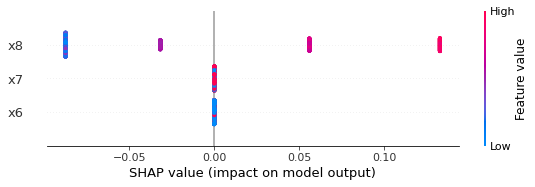

root - INFO - Getting value for save_shap_summary_plot
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


    0         1
0  x0       0.0
1  x1       0.0
2  x2       0.0
3  x3       0.0
4  x4       0.0
5  x5       0.0
6  x6       0.0
7  x7       0.0
8  x8  0.081753
  column_name shap_importance
0          x0             0.0
1          x1             0.0
2          x2             0.0
3          x3             0.0
4          x4             0.0
5          x5             0.0
6          x6             0.0
7          x7             0.0
8          x8        0.081753
  column_name shap_importance
8          x8        0.081753
0          x0             0.0
1          x1             0.0
2          x2             0.0
3          x3             0.0
4          x4             0.0
5          x5             0.0
6          x6             0.0
7          x7             0.0
  column_name shap_importance
8          x8        0.081753
0          x0             0.0
1          x1             0.0


In [8]:

pipeline = Pipeline([
            # feature selection
            ('random_xgbse', random_xgbse),

 ])

X_train=pipeline.fit_transform(X_train,y_train_fs)


# Transform X_test

X_train already transformed (features already selected), it is time to transform X_text



In [9]:
X_test = pipeline.transform(X_test)

# Prepare for using XGBSEKaplanNeighbors and fit the model

Note that features already selected by the above pipeline


In [10]:

# fitting xgbse model
xgbse_model = xgbse.XGBSEDebiasedBCE()
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
y_pred = xgbse_model.predict(X_test)

print(y_pred.shape)
y_pred.head()


(635, 20)


,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.988457,0.951992,0.917748,0.894999,0.857367,0.744759,0.695067,0.656383,0.626517,0.582831,0.550359,0.498549,0.471531,0.420150,0.343943,0.276323,0.234998,0.197158,0.160678,0.117115
1,0.962961,0.899493,0.830915,0.686187,0.641077,0.563583,0.434710,0.354465,0.310763,0.300019,0.234044,0.190015,0.157334,0.131209,0.098454,0.078969,0.069971,0.047585,0.039659,0.029250
2,0.991113,0.958020,0.918356,0.884887,0.853819,0.759216,0.725029,0.630986,0.561856,0.472877,0.447535,0.425983,0.398551,0.361272,0.313742,0.252497,0.202492,0.149729,0.128412,0.091805
3,0.988796,0.959173,0.869733,0.827470,0.788397,0.699229,0.620619,0.540580,0.503725,0.474142,0.434164,0.395908,0.367339,0.335113,0.274223,0.224630,0.184353,0.142219,0.120744,0.085730
4,0.982556,0.959433,0.897989,0.857152,0.786782,0.689115,0.610282,0.554854,0.537577,0.494436,0.435023,0.409009,0.376665,0.307758,0.237082,0.200328,0.168579,0.134569,0.110871,0.080289


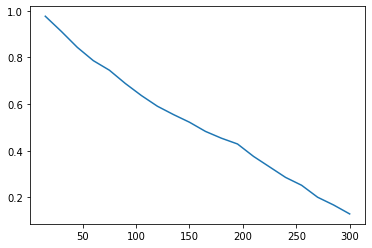

In [11]:
y_pred.mean().plot.line();


# Neighbors
We can also use our model for querying comparables based on survivability.

In [12]:
neighbors = xgbse_model.get_neighbors(
    query_data = X_test,
    index_data = X_train,
    n_neighbors = 5
)

print(neighbors.shape)
neighbors.head(5)

(635, 5)


,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
829,418,628,324,646,296
670,588,1846,864,1082,1046
1064,416,411,1133,1252,44
85,137,84,274,1250,1188
1814,1143,344,531,1214,477


example: selecting a data point from query data (X_test) and checking its features



In [13]:
desired = neighbors.iloc[10]

X_test.loc[X_test.index == desired.name]

,x8,x0,x1
399,67.620003,5.572504,7.367552


... and finding its comparables from index data (X_train)



In [14]:
X_train.loc[X_train.index.isin(desired.tolist())]


,x8,x0,x1
1433,68.419998,5.394643,7.909094
590,66.239998,5.521431,7.356899
117,68.989998,5.385737,7.828917
484,68.160004,5.508068,9.508301
209,66.220001,5.553239,7.499229


# Score metrics
XGBSE implements concordance index and integrated brier score, both can be used to evaluate model performance



In [15]:
# running metrics
print(f"C-index: {concordance_index(y_test, y_pred)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, y_pred)}")

C-index: 0.6443746930583136
Avg. Brier Score: 0.17668759163923328


It is interesting to see that obtained results by using only selected three features are comparable to the original example in 

https://notebooks.githubusercontent.com/view/ipynb?browser=unknown_browser&color_mode=auto&commit=6247a15dae2d75babd8cbe55d281ab117c92e3f5&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6c6f66742d62722f7867626f6f73742d737572766976616c2d656d62656464696e67732f363234376131356461653264373562616264386362653535643238316162313137633932653366352f6578616d706c65732f62617369635f75736167652e6970796e62&logged_in=false&nwo=loft-br%2Fxgboost-survival-embeddings&path=examples%2Fbasic_usage.ipynb&platform=unknown_platform&repository_id=329317418&repository_type=Repository&version=0

the model used all eight features with the same test and train data and parameters. 